# Property Calculations (MDTraj)

In [17]:
# Cusotm imports
from polymer_utils import general
from polymer_utils.representation import PolymerDir, PolymerDirManager

# General imports
import re
from pathlib import Path
from datetime import datetime

# Numeric processing and plotting
import mdtraj as mdt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data structures and combinatorics
from collections import defaultdict
from itertools import product, combinations

# Typing and Subclassing
from typing import Any, Callable, Optional
import dataclasses
from dataclasses import dataclass, field

# Units
from openmm.unit import Unit, Quantity # purely for typehints
from openmm.unit import nanometer, dimensionless

In [18]:
@dataclass
class PolyProp:
    '''A polymer property, containing a calculation method (based on MDTraj trajectory) and an additional info'''
    calc   : Callable
    name   : str
    abbr   : str
    unit   : Unit
    kwargs : dict = field(default_factory=dict)

    def compute(self, traj : mdt.Trajectory):
        '''Apply method to a trajectory'''
        return self.calc(traj, **self.kwargs)
    
def presize_subplots(nrows : int, ncols : int, scale : float=15.0, elongation : float=1.0) -> tuple[plt.Figure, np.ndarray[plt.Axes]]:
    '''
    Prepare a grid of predetermined number of matplotlib subplot axes of a particular size and aspect ratio
    Returns the resulting Figure and array of individual subplot Axes 
    '''
    aspect = (nrows / ncols) * elongation
    return plt.subplots(nrows, ncols, figsize=(scale, aspect*scale))

def plot_rdfs(traj : mdt.Trajectory, rad_unit : Unit=nanometer, save_path : Path=None) -> None:
    '''Plot pairwise radial distributions functions for all possible pairs of elements in a simulation trajectory'''
    elem_types = set(atom.element.symbol for atom in traj.topology.atoms)
    fig, ax = presize_subplots(nrows=1, ncols=len(elem_types), scale=15.0)
    fig.suptitle('Pairwise Radial Distribution Functions', fontsize=20)

    for curr_ax, (elem1, elem2) in zip(ax.flatten(), combinations(elem_types, 2)):
        atom_id_pairs = traj.topology.select_pairs(f'element {elem1}', f'element {elem2}')
        rdf = mdt.compute_rdf(traj, pairs=atom_id_pairs, r_range=(0.0, 1.0))

        curr_ax.plot(*rdf)
        curr_ax.set_xlabel(f'Radial distance ({rad_unit.get_symbol()})')
        curr_ax.set_ylabel(f'g(r) - {elem1} vs {elem2}')

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_poly_props(traj : mdt.Trajectory, properties : list[PolyProp], sample_interval : int, save_path : Path=None) -> None:
    '''Compute and plot a battery of labelled and unit-ed properties over a given trajectory'''
    frame_nums = np.arange(0, traj.n_frames * sample_interval, step=sample_interval)
    fig, ax = presize_subplots(nrows=1, ncols=len(properties))
    fig.suptitle('Polymer Shape and Gyration Properties', fontsize=20)

    for curr_ax, prop in zip(ax.flatten(), properties):
        curr_ax.plot(frame_nums, prop.compute(traj))
        curr_ax.set_xlabel('Trajectory frame')
        curr_ax.set_ylabel(f'{prop.name} ({prop.unit.get_symbol()})')

    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## Load trajectory and calculate/plot properties

In [20]:
POLY_PATH = Path('Polymers')
SAMPLE_INTERVAL = 10

mgr = PolymerDirManager(POLY_PATH)
pdir = mgr.mol_dirs['peg_modified_solv_water']
dated_sims = sorted(pdir.completed_sims, key = lambda sim_dir : datetime.strptime(sim_dir.stem, general.DATETIME_FMT))

dated_sims

[PosixPath('Polymers/peg_modified/peg_modified_solv_water/MD/03-17-2023_at_10-11-44_AM'),
 PosixPath('Polymers/peg_modified/peg_modified_solv_water/MD/03-17-2023_at_13-11-55_PM')]

In [21]:
topo_path = pdir.info.structure_file
traj_path = next(path for path in dated_sims[0].iterdir() if path.suffix == '.pdb')

traj = mdt.load(traj_path, top=topo_path, stride=SAMPLE_INTERVAL)
traj = traj.remove_solvent(inplace=True) # don't generate new copy when de-solvating
topo = traj.topology

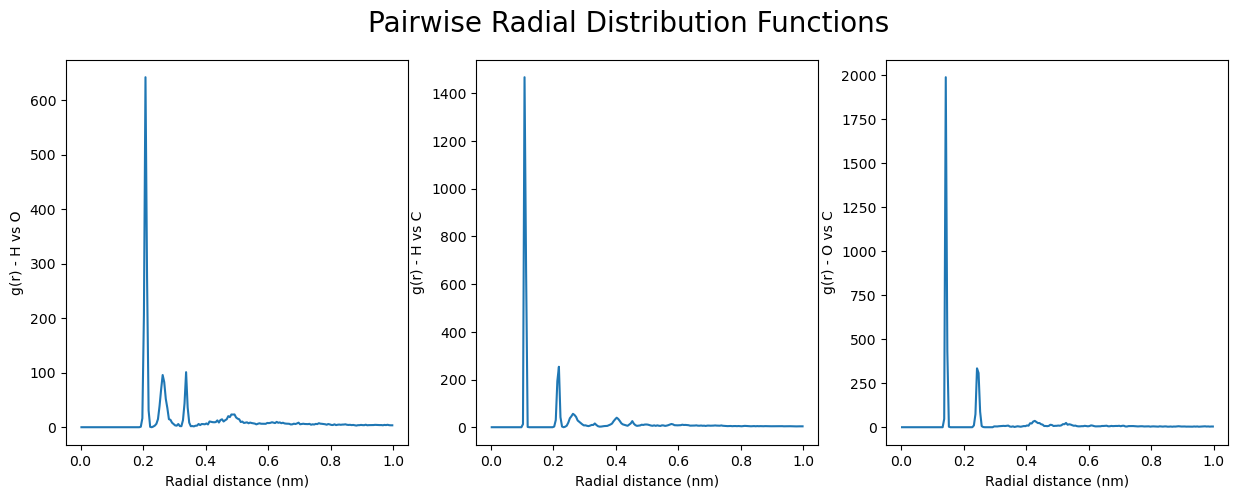

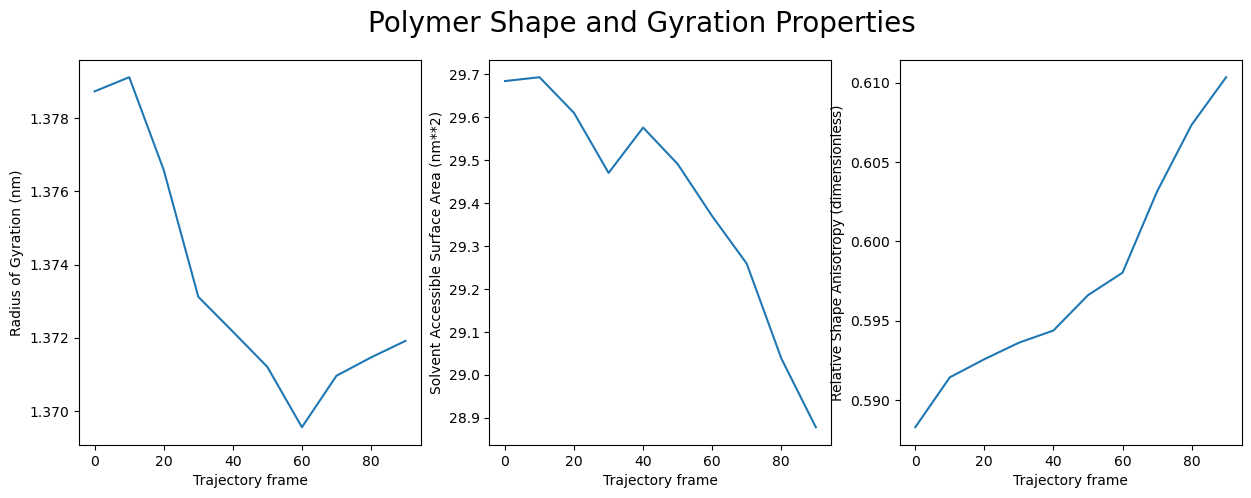

In [22]:
props = [
    PolyProp(calc=mdt.compute_rg                , name='Radius of Gyration'             , abbr='Rg'  , unit=nanometer),
    PolyProp(calc=mdt.shrake_rupley             , name='Solvent Accessible Surface Area', abbr='SASA', unit=nanometer**2, kwargs={'mode' : 'residue'}),
    PolyProp(calc=mdt.relative_shape_antisotropy, name='Relative Shape Anisotropy'      , abbr='K2'  , unit=dimensionless)    
]

plot_rdfs(traj)
plot_poly_props(traj, props, sample_interval=SAMPLE_INTERVAL)

In [ ]:
mgr.all_completed_sims.keys()

## Custom Implementations of Polymer Property Calculations (MDA)

In [ ]:
import MDAnalysis as mda
from MDAnalysis import Universe
from MDAnalysis.topology.LAMMPSParser import DATAParser
from MDAnalysis.coordinates.PDB import PDBReader, PDBWriter
from MDAnalysis.topology.TOPParser import TOPParser
# from MDAnalysis.topology.PDBParser import PDBParser
# from MDAnalysis.topology.HoomdXMLParser import HoomdXMLParser

In [ ]:
import matplotlib.pyplot as plt

def scatter_3D(array : np.array) -> None:
    x, y, z = array.T

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z)

def compute_gyration_tensor(coords : np.ndarray, use_eins=True) -> np.ndarray:
    '''Determines the gyration tensor of a set of atomic coordinates (and its diagonalization)
    Expects coordinates in an Nx3 array, with each column representing the x, y, and z coordinates, respectively'''
    N, ncols = arr_shape = coords.shape
    if ncols != 3:
        raise ValueError(f'Coordinate array must be of shape Nx3, not {arr_shape}')

    COM = coords.mean(axis=0) # centre-of-mass coord
    rs = coords - COM # place origin at center of mass

    if use_eins: # use Einstein summation for notational and memory compactness
        gyr_tens = np.einsum('ij, ik->jk', rs, rs) / N 
    else: # use direct displacement summation, less efficient but easier to understand
        gyr_tens = np.zeros((3, 3))
        for point in rs:
            S_i = np.outer(point, point)
            gyr_tens += S_i
        gyr_tens /= N

    return gyr_tens

def diagonalize(matrix : np.ndarray) -> list[np.ndarray]:
    '''Performs eigendecomposition of a matrix
    Returns the basis and diagonal matrices as a list [P, D, P^-1]''' 
    eivals, eivecs = np.linalg.eig(matrix) # perform eigendecomposition to obtain principle components
    return [eivecs, np.diag(eivals), np.linalg.inv(eivecs)] # return vector containing P, D, and P^-1

def compute_Rg_and_K2(gyr_tens : np.ndarray, use_diag : bool=False) -> tuple[float, float]:
    '''Determine the radius of gyration (Rg) and radial shape anisotropy (K2) from a molecules gyration tensor'''
    if use_diag:
        P, D, P_inv = diagonalize(G)
        I1 = np.trace(D)
        I2 = (I1**2 - np.trace(D**2)) / 2
    else:
        S, _eivecs = np.linalg.eig(G)
        I1 = S.sum()
        I2 = (I1**2 - np.sum(S**2)) / 2

    Rg = np.sqrt(I1)
    K2 = 1 - 3*(I2 / I1**2)
    
    return Rg, K2

In [ ]:
topo_path = Path('compatible_pdbs/simple_polymers/polyvinylchloride.pdb')
traj_path = Path('averaged_polymers/polyvinylchloride/polyvinylchloride_frames.pdb')
u = Universe(traj_path)

In [ ]:

coords = np.array([atom.position for atom in u.atoms])
scatter_3D(coords)

Rg1 = u.atoms.radius_of_gyration()
G = compute_gyration_tensor(coords)
Rg2, K2 = compute_Rg_and_K2(G)

print(Rg1, '\n', Rg2, K2)

## Testing for mbuild pdb completion (filling in bonding info from other formats)

In [ ]:
N = 10
mol_name = 'polyethylmethacrylate'
source_dir = Path(f'mbuild_polymers/PDB save test/{mol_name}')
file_stem = f'mbuild_{mol_name}'#-N={N}'

pdb_path    = source_dir/f'{file_stem}.pdb'
hoomd_path  = source_dir/f'{file_stem}.hoomdxml'
lammps_path = source_dir/f'{file_stem}.lmp'
gsd_path    = source_dir/f'{file_stem}.gsd'
top_path    = source_dir/f'{file_stem}.top'

# hoomd_parser = HoomdXMLParser(hoomd_path)
# hoomd_parser.parse()

lammps_parser = DATAParser(str(lammps_path))
topo = lammps_parser.parse()
# read = PDBReader(pdb_path)

u = Universe(topo, pdb_path) # use explicit topology but implicit trajectory (traj from pdb)

In [ ]:
polymer = u.select_atoms('all')
outpath = source_dir/f'mda_{mol_name}.pdb'

with mda.Writer(outpath, multiframe=False) as pdb:
    pdb.write(polymer)

## Some other stuff